In [1]:
import string
import re 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import csv
import multiprocessing
from multiprocessing import Pool
import nltk
import os

Make sure you have downloaded your Kaggle token on your local machine. You will get a `kaggle.json` file that you can open with your favorite text editor. You will be able to see something like this:
`{“username”:”YOUR-USER-NAME”,”key”:”SOMETHING-VERY-LONG”}`. Next, you can copy and paste your username and key in the following cell so you can configure appropiate credentials to download the data in the next steps.

In [2]:
os.environ["KAGGLE_USERNAME"] = "YOUR-USER-NAME"
os.environ["KAGGLE_KEY"] = "SOMETHING-VERY-LONG"

# 1. Get the data

In [4]:
! kaggle datasets download stackoverflow/stacksample

100%|█████████████████████████████████████▉| 1.11G/1.11G [01:37<00:00, 12.1MB/s]
100%|██████████████████████████████████████| 1.11G/1.11G [01:37<00:00, 12.2MB/s]


In [5]:
%%bash
mkdir stacksample
unzip -j stacksample.zip Questions.csv -d stacksample/ 
unzip -j stacksample.zip Tags.csv -d stacksample/
rm stacksample.zip
mkdir data models predictions

Archive:  stacksample.zip
  inflating: stacksample/Questions.csv  
Archive:  stacksample.zip
  inflating: stacksample/Tags.csv    


# 2. Preparing the data

We begin by loading the data (both the Questions and Tags tables) by chunks. We have followed the same approach as in [Yi Ai's](https://medium.com/@yia333) [Medium post](https://medium.com/hackernoon/auto-generating-tags-for-content-using-amazon-sagemaker-blazingtext-with-fasttext-335c38429de0).

In [6]:
QuestionsFile = "stacksample/Questions.csv"
chunksize = 20000

df = None
for ratings in pd.read_csv(QuestionsFile, names=['id', 'title', 'body'], encoding = 'ISO-8859-1',  header=None , usecols=[0,5,6],error_bad_lines = False, chunksize=chunksize):
    if df is None:
        df = ratings.copy()
    else:
        df.append(ratings)
        
TagsFile = "stacksample/Tags.csv"
chunksize = 20000
df_tags = None
for ratings in pd.read_csv(TagsFile, names=['id', 'tag'], header=None , chunksize=chunksize):
    if df_tags is None:
        df_tags = ratings.copy()
    else:
        df_tags.append(ratings)

# 3. Data Exploration & Visualization

Let's compute statistics over the frequency counts of the *tag* field in the tags dataframe.

In [7]:
df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).to_frame().describe()

,tag
count,3506.000000
mean,5.702510
std,27.213578
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,862.000000


Let's plot a histogram over the top-100 most frequent tags.

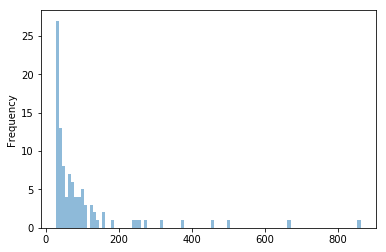

In [8]:
df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).head(100).plot.hist(bins=100, alpha=0.5)

Create a dataframe with tags and frequency counts with the top-100 most frequent tags.

In [9]:
mytags = df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).to_frame().head(100).reset_index()

Let's compute statistics as before, for the subset of the top-100 most frequent tags.

In [10]:
mytags.describe()

,tag
count,100.000000
mean,99.230000
std,128.606506
min,29.000000
25%,37.000000
50%,56.000000
75%,98.250000
max,862.000000


### Wordcloud of the top-100 most frequent tags

In [11]:
d = {}
for a, x in mytags.values:
    d[a] = x

In [12]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate_from_frequencies(frequencies=d)

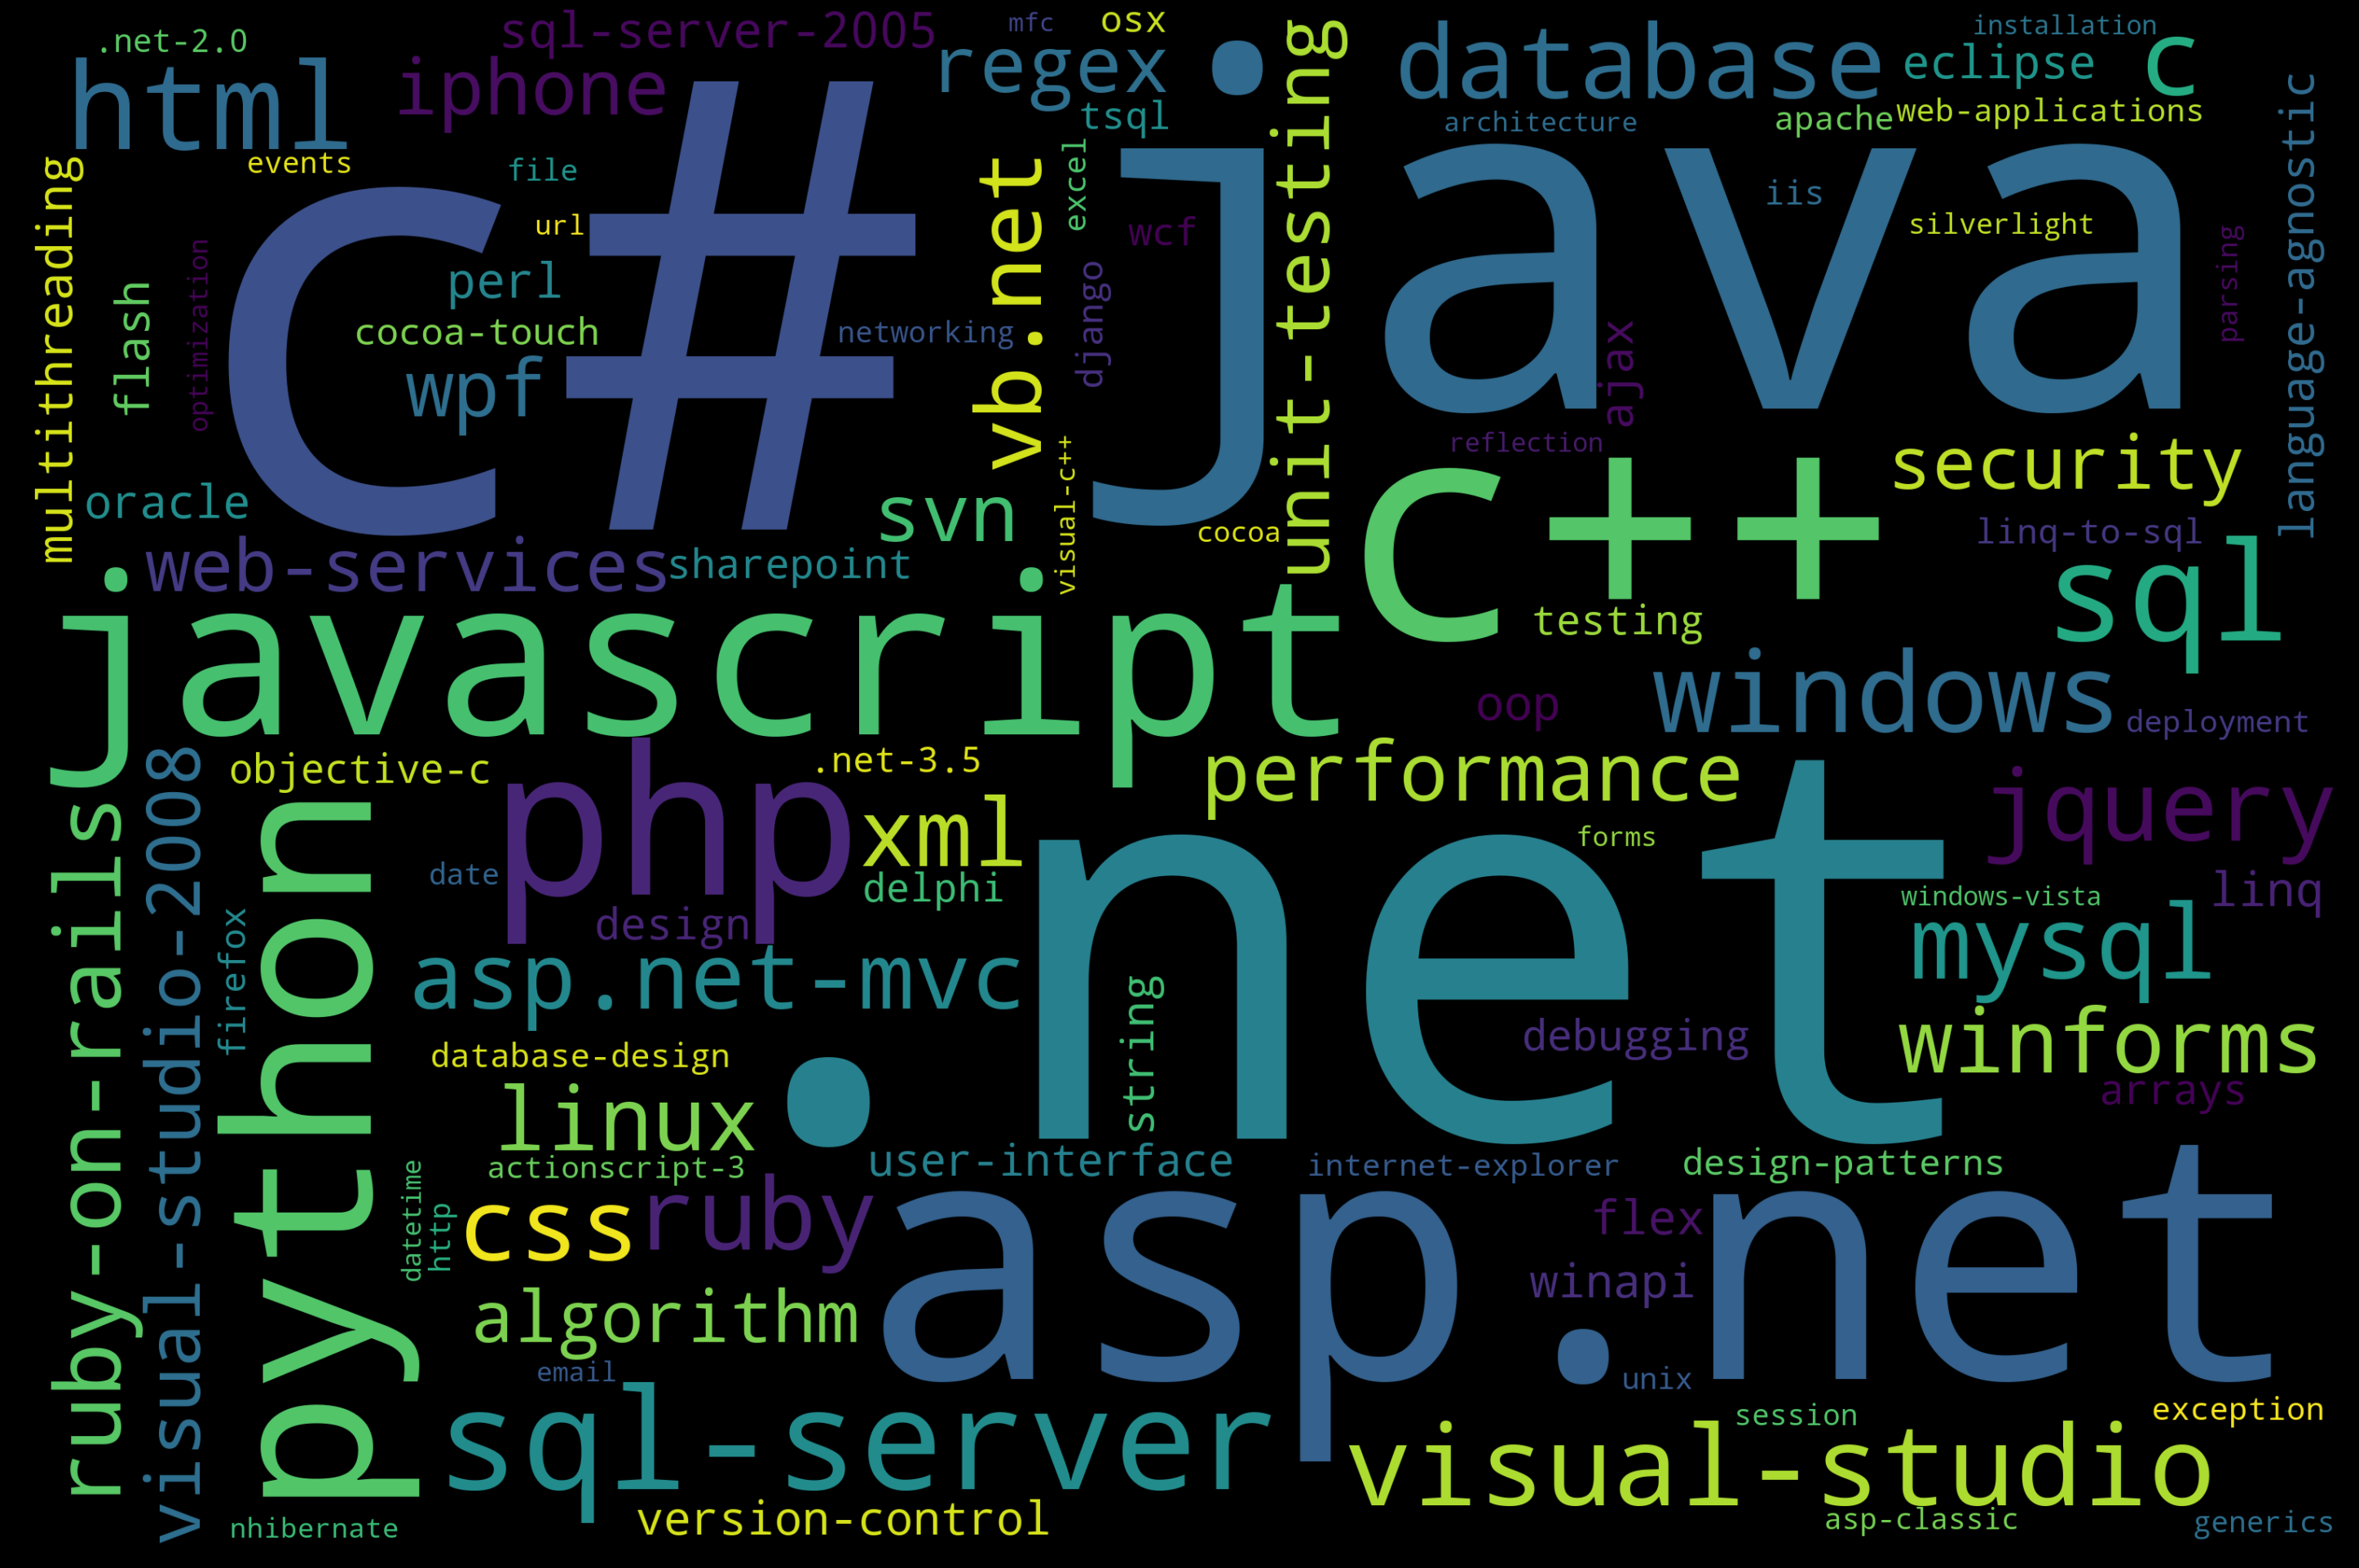

In [13]:
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
fig.savefig('toptags.png', dpi=fig.dpi)

Let's store the top-100 most frequent tags in a list.

In [14]:
topTags = df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).head(100).index.tolist()

Let's filter the tags dataframe based on the previous list.

In [15]:
df_tags = df_tags[df_tags.tag.isin(topTags)]

# 4. Processing the data

For both fastText and BlazingText, the input file has to be formatted in a way that each line contain a single sentence and the corresponding label(s) prefixed by __label__, e.g.  ``__label__database __label__oracle How to edit sessions parameters on Oracle 10g XE?``. Additionally, the input data has to be as clean as possible. The following function generates a preprocessed and clean data after removing HTML tags and unwanted punctuations. 

For both steps, we have followed the same approach as in [Yi Ai's](https://medium.com/@yia333) [Medium post](https://medium.com/hackernoon/auto-generating-tags-for-content-using-amazon-sagemaker-blazingtext-with-fasttext-335c38429de0). The following functions perform the aforementioned steps.

In [16]:
def clean_text(text):
    if not isinstance(text, str): 
        return text
    def cleanhtml(raw_html):
        cleanr = re.compile('<[^>]+>')
        cleantext = re.sub(cleanr, '', raw_html)
        return cleantext
    def replace_link(match):
        return '' if re.match('[a-z]+://', match.group(1)) else match.group(1)
    def removeContractions(raw_text):
        CONTRACTIONS = {"mayn't":"may not", "may've":"may have","isn't":"is not","wasn't":"was not","'ll":" will","'have": "have"}
        raw_text = raw_text.replace("’","'")
        words = raw_text.split()
        reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
        raw_text = " ".join(reformed)
        return raw_text
    text = cleanhtml(text)
    text = removeContractions(text)
    text = re.sub('<pre><code>.*?</code></pre>', '', text)
    text = re.sub('<a[^>]+>(.*)</a>', replace_link, text)
    #Remove hashtags
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", text).split())
    #Remove punctuations
    text = ' '.join(re.sub("[\.\,\(\)\{\}\[\]\`\'\!\?\:\;\-\=]", " ", text).split())
    #text = text.translate(str.maketrans('','',string.punctuation))
    text = text.lower()
    return text

In [17]:
questions = df.values
tags = df_tags.values

all_rows=[]

for index, row in enumerate(questions):
    title = clean_text(row[1])
    tag_ids = [ tag[1] for tag_idx, tag in enumerate(tags) if tag[0]  == row[0] ]
    if(len(tag_ids)>0): 
        all_rows.append({"title":title, "tags":tag_ids})

In [18]:
nltk.download('punkt')

def preprocess(rows,output_file):
    pool = Pool(processes=multiprocessing.cpu_count())
    transformed_rows = pool.map(transform_instance, rows)
    pool.close() 
    pool.join()
    with open(output_file, "w") as txt_file:
        for line in transformed_rows:
            txt_file.write(" ".join(line) + "\n")
            
def transform_instance(row):
    cur_row = []
    label = ["__label__" + str(tag) for tag in row["tags"] if tag]
    label = " ".join(map(str, label))
    cur_row.append(str(label))
    cur_row.extend(nltk.word_tokenize(row["title"]))
    return cur_row

[nltk_data] Downloading package punkt to /Users/pjcv89/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 5. Create training, validation and test sets and store them in local directory

## For fastText and StarSpace models

Apply the previous defined functions and split the data pseudorandomly on train, validation and test sets.

In [19]:
train, valid = train_test_split(all_rows,test_size=0.20,random_state=12345)
valid, test = train_test_split(valid,test_size=0.50,random_state=12345)

preprocess(train, 'data/train')    
preprocess(valid, 'data/valid')
preprocess(test, 'data/test')

In [20]:
pdf_test = pd.DataFrame(test).explode('tags')

# 6. Building and Training the Models

Before training and using the models for predictions, let's take our test set and make a list with the true tags for each instance in the set. We are going to collect predictions for each model and append a new column to this dataframe with the corresponding predictions each time.

In [21]:
indexes = pdf_test.title.unique()
grouped = pdf_test.groupby('title').apply(lambda x: list(x.tags)).to_frame().reindex(indexes).reset_index().rename(columns={0: "true"})
grouped['n_tags'] = grouped['true'].apply(lambda x: len(x))

Let's take a small sample. This will be our working sample to show predictions for each model from now on.

In [22]:
grouped[grouped['n_tags']>2].sample(15,random_state=12345).drop(columns='n_tags')

,title,true
253,asp net 3 5 bind to xml string,"[asp.net, xml, string]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]"
323,what s the best way to parse a body of text ag...,"[ruby, regex, performance, parsing]"
219,how to present credentials in order to open file,"[c#, .net, security]"
568,how do exceptions work behind the scenes in c++,"[c++, performance, exception]"
450,using xquery in linq to sql,"[linq, sql-server-2005, linq-to-sql]"
85,sending email in net through gmail,"[c#, .net, email]"
356,network interface settings in embedded windows xp,"[c++, c, winapi, networking]"
107,parsing t sql to parameterize a query,"[.net, sql-server, parsing]"
155,how do i use linq contains string instead of c...,"[c#, linq, string]"


## 6.1 fastText

For the fastText model to use as baseline, we use the same settings as reported in [Yi Ai's](https://medium.com/@yia333) [Medium post](https://medium.com/hackernoon/auto-generating-tags-for-content-using-amazon-sagemaker-blazingtext-with-fasttext-335c38429de0). In this case, for quick training and predicting, we can use the data stored locally and use fastText locally. Note that if we would like to deploy the model for predictions via Amazon SageMaker and BlazingText, we can do in the same way he reports in the post.

Train the fastText model in local mode.

In [23]:
import fasttext
ft_baseline = fasttext.train_supervised(input="data/train", lr=0.1, epoch=10, wordNgrams=1,dim=100)

Note that we can compute average *precision@k* and *recall@k* over the test set using fastText built-in tool for metrics.

In [24]:
[ft_baseline.test("data/test",k=i) for i in range(1,5)]

[(591, 0.338409475465313, 0.1958863858961802),
 (591, 0.23942470389170897, 0.277179236043095),
 (591, 0.18274111675126903, 0.31733594515181196),
 (591, 0.1476311336717428, 0.3418217433888345)]

Let's make it with a neater format.

In [25]:
metrics = pd.DataFrame([ft_baseline.test("data/test",k=i) for i in range(1,5)]) \
            .rename(columns={'index':'at',0:'n',1:'precision',2:'recall'}) \
            .drop(columns=['n'])
metrics.index=metrics.index+1
metrics = metrics.rename('at_{}'.format)
display(metrics)

,precision,recall
at_1,0.338409,0.195886
at_2,0.239425,0.277179
at_3,0.182741,0.317336
at_4,0.147631,0.341822


If we want to persist this model we can do it by using its *save_model* method.

In [26]:
ft_baseline.save_model("models/ft_baseline.bin")
del ft_baseline

And we can load it using fastText's load_model function.

In [27]:
ft_baseline = fasttext.load_model("models/ft_baseline.bin")

Let's define a function to perform predictions and get the top-3 most probable tags for each instance of the test set.

In [28]:
def get_FTpredictions(model,sentence,threshold=None,k=3):
    if threshold:
        labels, probs = model.predict(sentence.lower(),k=k)
        candidates = [labels[index]  for index in range(0,k) if probs[index] >= threshold]
    else:
        candidates = model.predict(sentence.lower(),k=k)[0]
    output = [candidate.replace("__label__","") for candidate in candidates]
    return output

Apply the previous function over the *title* field in the test set.

In [29]:
grouped['ft_baseline'] = grouped.title.apply(lambda sentence: get_FTpredictions(ft_baseline,sentence))

Let's take a look to predictions on our small sample.

In [30]:
grouped[grouped['n_tags']>2].sample(15,random_state=12345).drop(columns='n_tags')

,title,true,ft_baseline
253,asp net 3 5 bind to xml string,"[asp.net, xml, string]","[asp.net, .net, asp.net-mvc]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]"
323,what s the best way to parse a body of text ag...,"[ruby, regex, performance, parsing]","[c#, .net, java]"
219,how to present credentials in order to open file,"[c#, .net, security]","[c#, .net, asp.net]"
568,how do exceptions work behind the scenes in c++,"[c++, performance, exception]","[c++, python, java]"
450,using xquery in linq to sql,"[linq, sql-server-2005, linq-to-sql]","[sql-server, sql, sql-server-2005]"
85,sending email in net through gmail,"[c#, .net, email]","[asp.net, .net, c#]"
356,network interface settings in embedded windows xp,"[c++, c, winapi, networking]","[c#, c++, .net]"
107,parsing t sql to parameterize a query,"[.net, sql-server, parsing]","[sql-server, sql, c#]"
155,how do i use linq contains string instead of c...,"[c#, linq, string]","[c#, java, .net]"


##  Hyperparameter autotuning

Current version of fastText's Python API stored in PyPI (0.9.1 version, as of March 2020) doesn't support the hyperparameter autotuning tool yet. However, CLI does and that is why we downloaded both API's. We can use the autotune in the following way. Please note that we can fix a specific hyperaparameter (in this example, the embedding dimension `dim`), and also we can constrain the model size via `autotune-modelsize` parameter, since it is also a hyperparameter! We also need to provide a time constraint in seconds via the `autotune-duration` parameter.

In [31]:
! fastText/build/fasttext supervised -input data/train -autotune-validation data/valid -output models/ft_tuned -dim 100 -autotune-duration 900 -autotune-modelsize 10M

Progress: 100.0% Trials:   22 Best score:  0.458015 ETA:   0h 0m 0s57ssm35s31s32s13m22s  0h13m17s0.262087 ETA:   0h12m48s  0h12m32s0h12m18s Trials:    3 Best score:  0.262087 ETA:   0h12m 7s   3 Best score:  0.262087 ETA:   0h11m59s  0h11m24s5 Best score:  0.262087 ETA:   0h11m 2s  0h10m59s0h10m 2s0h 9m44s 0.340967 ETA:   0h 9m34s1s8m41s ETA:   0h 7m39s0h 6m23s Trials:   14 Best score:  0.400763 ETA:   0h 5m43s 5m25s0h 5m 4s26s% Trials:   17 Best score:  0.441476 ETA:   0h 3m20s  0h 3m13s  0h 3m 4s35s0.458015 ETA:   0h 1m 0s48s0h 0m23s
Training again with best arguments
Read 0M words
Number of words:  5601
Number of labels: 100
Progress: 100.0% words/sec/thread:  167200 lr:  0.000000 avg.loss:  0.974468 ETA:   0h 0m 0s ETA:   0h 0m 1s
Progress: 100.0% words/sec/thread:  154231 lr:  0.000000 avg.loss:  0.698858 ETA:   0h 0m 0s


The tuned model is persisted in the specified location. We can load it as before so we can use it interactively here.

In [32]:
ft_tuned = fasttext.load_model("models/ft_tuned.ftz")

Let's see the metrics as before.

In [33]:
metrics = pd.DataFrame([ft_tuned.test("data/test",k=i) for i in range(1,5)]) \
            .rename(columns={'index':'at',0:'n',1:'precision',2:'recall'}) \
            .drop(columns=['n'])
metrics.index=metrics.index+1
metrics = metrics.rename('at_{}'.format)
display(metrics)

,precision,recall
at_1,0.619289,0.358472
at_2,0.435702,0.504407
at_3,0.329385,0.571988
at_4,0.271997,0.629775


In [34]:
grouped['ft_tuned'] = grouped.title.apply(lambda sentence: get_FTpredictions(ft_tuned,sentence))

In [35]:
grouped[grouped['n_tags']>2].sample(20,random_state=12345).drop(columns='n_tags')

,title,true,ft_baseline,ft_tuned
253,asp net 3 5 bind to xml string,"[asp.net, xml, string]","[asp.net, .net, asp.net-mvc]","[asp.net, .net, xml]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql, sql-server, database]"
323,what s the best way to parse a body of text ag...,"[ruby, regex, performance, parsing]","[c#, .net, java]","[arrays, c++, parsing]"
219,how to present credentials in order to open file,"[c#, .net, security]","[c#, .net, asp.net]","[c#, windows, .net]"
568,how do exceptions work behind the scenes in c++,"[c++, performance, exception]","[c++, python, java]","[c++, c, mfc]"
450,using xquery in linq to sql,"[linq, sql-server-2005, linq-to-sql]","[sql-server, sql, sql-server-2005]","[linq, sql, linq-to-sql]"
85,sending email in net through gmail,"[c#, .net, email]","[asp.net, .net, c#]","[.net, email, python]"
356,network interface settings in embedded windows xp,"[c++, c, winapi, networking]","[c#, c++, .net]","[windows, winapi, c#]"
107,parsing t sql to parameterize a query,"[.net, sql-server, parsing]","[sql-server, sql, c#]","[sql, sql-server, tsql]"
155,how do i use linq contains string instead of c...,"[c#, linq, string]","[c#, java, .net]","[string, linq, .net]"


## 6.2 StarSpace

In [36]:
! Starspace/starspace train -trainFile data/train -validationFile data/valid -useWeight 0 -model models/ss_unweighted -loss softmax -lr 0.1 -epoch 10 -batchSize 1 -ngrams 1 -adagrad 0

Arguments: 
lr: 0.1
dim: 100
epoch: 10
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: softmax
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 1
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 0
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to initialize starspace model.
Build dict from input file : data/train
Read 0M words
Number of words in dictionary:  5600
Number of labels in dictionary: 100
Loading data from file : data/train
Total number of examples loaded : 4726
Loading data from file : data/valid
Total number of examples loaded : 590
Training epoch 0: 0.1 0.01
Epoch: 99.8%  lr: 0.090000  loss: 3.661566  eta: <1min   tot: 0h0m0s  (10.0%)
 ---+++                Epoch    0 Train error : 3.66907525 +++--- ☃
Epoch: 98.5%  lr: 0.000000  loss: 3.584735  eta: <1min   tot: 0h0m0s  (9.8%)
Validation error: 3.589

In [37]:
! Starspace/starspace test -model models/ss_unweighted.tsv -testFile data/test -predictionFile predictions/rawpreds -K 3

Arguments: 
lr: 0.01
dim: 100
epoch: 5
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: hinge
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 5
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 1
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to load a trained embedding model in tsv format.
Loading dict from model file : models/ss_unweighted.tsv
Number of words in dictionary:  5600
Number of labels in dictionary: 100
Loading model from file models/ss_unweighted.tsv
Model loaded.
Loading data from file : data/test
Total number of examples loaded : 591
Predictions use 100 known labels.
Evaluation Metrics : 
hit@1: 0.181049 hit@10: 0.571912 hit@20: 0.705584 hit@50: 0.900169 mean ranks : 17.4129 Total examples : 591


In [38]:
%%bash
cd predictions   
grep -A3 Predictions: rawpreds | awk -F'__label__' '{print $2}' | awk -v RS= '{gsub(/\n/, " ")}3'  > preds 
awk '/LHS:/ {for(i=1; i<=1; i++) {getline; print}}' rawpreds > lhss 
paste -d ',' lhss preds > cleanpreds && rm lhss preds

In [39]:
ss_predictions = pd.read_csv('predictions/cleanpreds',sep=',',names=['title','ss_unweighted'])
ss_predictions['title'] = ss_predictions['title'].str.strip()
ss_predictions['ss_unweighted'] = ss_predictions['ss_unweighted'].str.strip().apply(lambda x: x.split('  '))

In [40]:
grouped = grouped.merge(ss_predictions.drop(columns=['title']),left_index=True,right_index=True)

In [41]:
grouped[grouped['n_tags']>2].sample(20,random_state=12345).drop(columns='n_tags')

,title,true,ft_baseline,ft_tuned,ss_unweighted
253,asp net 3 5 bind to xml string,"[asp.net, xml, string]","[asp.net, .net, asp.net-mvc]","[asp.net, .net, xml]","[asp.net, .net-3.5, .net]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql, sql-server, database]","[sql-server, sql, sql-server-2005]"
323,what s the best way to parse a body of text ag...,"[ruby, regex, performance, parsing]","[c#, .net, java]","[arrays, c++, parsing]","[http, email, unix]"
219,how to present credentials in order to open file,"[c#, .net, security]","[c#, .net, asp.net]","[c#, windows, .net]","[file, deployment, windows]"
568,how do exceptions work behind the scenes in c++,"[c++, performance, exception]","[c++, python, java]","[c++, c, mfc]","[visual-c++, debugging, winapi]"
450,using xquery in linq to sql,"[linq, sql-server-2005, linq-to-sql]","[sql-server, sql, sql-server-2005]","[linq, sql, linq-to-sql]","[linq-to-sql, sql, linq]"
85,sending email in net through gmail,"[c#, .net, email]","[asp.net, .net, c#]","[.net, email, python]","[email, apache, php]"
356,network interface settings in embedded windows xp,"[c++, c, winapi, networking]","[c#, c++, .net]","[windows, winapi, c#]","[windows, winapi, networking]"
107,parsing t sql to parameterize a query,"[.net, sql-server, parsing]","[sql-server, sql, c#]","[sql, sql-server, tsql]","[tsql, sql, sql-server]"
155,how do i use linq contains string instead of c...,"[c#, linq, string]","[c#, java, .net]","[string, linq, .net]","[string, date, tsql]"


## Label weights 

In [42]:
df_labels = pd.read_csv('data/train',names=['single'])

In [43]:
df_labels.head(10)

,single
0,__label__.net how can you determine what versi...
1,__label__database __label__oracle __label__dat...
2,__label__java __label__python __label__web-ser...
3,__label__perl __label__datetime __label__parsi...
4,__label__regex regex in vb6
5,__label__ruby-on-rails __label__ruby rspec sto...
6,__label__oracle oracle single table constant m...
7,__label__java __label__algorithm programming p...
8,__label__java csv api for java
9,__label__python what is the naming convention ...


In [44]:
df_labels['text'] = df_labels['single'].apply(lambda x: x.split(" ")) \
.apply(lambda line: list(filter(lambda x: "__label__" not in x, line))) \
.apply(lambda line: ' '.join(line))

df_labels['single'] = df_labels['single'].apply(lambda x: x.split(" ")) \
.apply(lambda line: list(filter(lambda x: "__label__" in x, line))).to_frame()

In [45]:
df_labels.head(10)

,single,text
0,[__label__.net],how can you determine what version s of net ar...
1,"[__label__database, __label__oracle, __label__...",what is the best approach for decoupled databa...
2,"[__label__java, __label__python, __label__web-...",testing web services consumer
3,"[__label__perl, __label__datetime, __label__pa...",how can i parse dates and convert time zones i...
4,[__label__regex],regex in vb6
5,"[__label__ruby-on-rails, __label__ruby]",rspec stories and specs when to use what
6,[__label__oracle],oracle single table constant merge with clob u...
7,"[__label__java, __label__algorithm]",programming problem fax compression
8,[__label__java],csv api for java
9,[__label__python],what is the naming convention in python for va...


In [46]:
df_labels['n_labels'] = df_labels['single'].apply(lambda x: len(x))
df_labels = df_labels['single'].apply(pd.Series).add_prefix('label_').merge(df_labels.drop(columns=['single']),left_index=True,right_index=True)

In [47]:
df_labels.head(10)

,label_0,label_1,label_2,label_3,label_4,text,n_labels
0,__label__.net,NaN,NaN,NaN,NaN,how can you determine what version s of net ar...,1
1,__label__database,__label__oracle,__label__database-design,NaN,NaN,what is the best approach for decoupled databa...,3
2,__label__java,__label__python,__label__web-services,__label__testing,NaN,testing web services consumer,4
3,__label__perl,__label__datetime,__label__parsing,__label__date,NaN,how can i parse dates and convert time zones i...,4
4,__label__regex,NaN,NaN,NaN,NaN,regex in vb6,1
5,__label__ruby-on-rails,__label__ruby,NaN,NaN,NaN,rspec stories and specs when to use what,2
6,__label__oracle,NaN,NaN,NaN,NaN,oracle single table constant merge with clob u...,1
7,__label__java,__label__algorithm,NaN,NaN,NaN,programming problem fax compression,2
8,__label__java,NaN,NaN,NaN,NaN,csv api for java,1
9,__label__python,NaN,NaN,NaN,NaN,what is the naming convention in python for va...,1


In [48]:
def make_weights(n_labels):
    if n_labels == 1:
        weights = [1.0,0,0,0,0]
    elif n_labels == 2:
        weights = [0.75,0.25,0,0,0]
    elif n_labels == 3:
        weights = [0.50,0.30,0.20,0.0]
    elif n_labels == 4:
        weights = [0.40,0.25,0.20,0.15,0]
    elif n_labels == 5:
        weights = [0.30,0.25,0.20,0.15,0.10]
    return [":"+str(i) for i in weights]

In [49]:
df_labels = df_labels['n_labels'].apply(lambda n: make_weights(n)).apply(pd.Series).add_prefix('weight_') \
.merge(df_labels.drop(columns='n_labels'),left_index=True,right_index=True)

In [50]:
df_labels['label_0'] = df_labels['label_0']+df_labels['weight_0']
df_labels['label_1'] = df_labels['label_1']+df_labels['weight_1']
df_labels['label_2'] = df_labels['label_2']+df_labels['weight_2']
df_labels['label_3'] = df_labels['label_3']+df_labels['weight_3']
df_labels['label_4'] = df_labels['label_4']+df_labels['weight_4']

In [51]:
df_labels = df_labels[df_labels.columns.drop(list(df_labels.filter(regex='weight')))]

In [52]:
df_labels.head(10)

,label_0,label_1,label_2,label_3,label_4,text
0,__label__.net:1.0,NaN,NaN,NaN,NaN,how can you determine what version s of net ar...
1,__label__database:0.5,__label__oracle:0.3,__label__database-design:0.2,NaN,NaN,what is the best approach for decoupled databa...
2,__label__java:0.4,__label__python:0.25,__label__web-services:0.2,__label__testing:0.15,NaN,testing web services consumer
3,__label__perl:0.4,__label__datetime:0.25,__label__parsing:0.2,__label__date:0.15,NaN,how can i parse dates and convert time zones i...
4,__label__regex:1.0,NaN,NaN,NaN,NaN,regex in vb6
5,__label__ruby-on-rails:0.75,__label__ruby:0.25,NaN,NaN,NaN,rspec stories and specs when to use what
6,__label__oracle:1.0,NaN,NaN,NaN,NaN,oracle single table constant merge with clob u...
7,__label__java:0.75,__label__algorithm:0.25,NaN,NaN,NaN,programming problem fax compression
8,__label__java:1.0,NaN,NaN,NaN,NaN,csv api for java
9,__label__python:1.0,NaN,NaN,NaN,NaN,what is the naming convention in python for va...


In [53]:
df_labels = df_labels[df_labels.columns].apply(lambda x: ' '.join(x.dropna().astype(str)),axis=1).to_frame()

In [54]:
df_labels.head(10)

,0
0,__label__.net:1.0 how can you determine what v...
1,__label__database:0.5 __label__oracle:0.3 __la...
2,__label__java:0.4 __label__python:0.25 __label...
3,__label__perl:0.4 __label__datetime:0.25 __lab...
4,__label__regex:1.0 regex in vb6
5,__label__ruby-on-rails:0.75 __label__ruby:0.25...
6,__label__oracle:1.0 oracle single table consta...
7,__label__java:0.75 __label__algorithm:0.25 pro...
8,__label__java:1.0 csv api for java
9,__label__python:1.0 what is the naming convent...


In [55]:
df_labels.to_csv('data/train_weighted',index=False,sep=' ',header=False,encoding='utf-8',escapechar=' ',quoting=csv.QUOTE_NONE)

In [56]:
! Starspace/starspace train -trainFile data/train_weighted -validationFile data/valid -useWeight 1 -model models/ss_weighted -loss softmax -lr 0.1 -epoch 10 -batchSize 1 -ngrams 1 -adagrad 0

Arguments: 
lr: 0.1
dim: 100
epoch: 10
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: softmax
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 1
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 0
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 1
weightSep: :
Start to initialize starspace model.
Build dict from input file : data/train_weighted
Read 0M words
Number of words in dictionary:  5601
Number of labels in dictionary: 100
Loading data from file : data/train_weighted
Total number of examples loaded : 4726
Loading data from file : data/valid
Total number of examples loaded : 590
Training epoch 0: 0.1 0.01
Epoch: 99.8%  lr: 0.090000  loss: 3.970242  eta: <1min   tot: 0h0m1s  (10.0%) lr: 0.097500  loss: 3.981116  eta: <1min   tot: 0h0m0s  (3.8%)  eta: <1min   tot: 0h0m0s  (7.6%)
 ---+++                Epoch    0 Train error : 3.956

In [57]:
! Starspace/starspace test -model models/ss_weighted.tsv -testFile data/test -predictionFile predictions/rawpreds_weighted -K 3

Arguments: 
lr: 0.01
dim: 100
epoch: 5
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: hinge
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 5
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 1
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to load a trained embedding model in tsv format.
Loading dict from model file : models/ss_weighted.tsv
Number of words in dictionary:  5601
Number of labels in dictionary: 100
Loading model from file models/ss_weighted.tsv
Model loaded.
Loading data from file : data/test
Total number of examples loaded : 591
Predictions use 100 known labels.
Evaluation Metrics : 
hit@1: 0.208122 hit@10: 0.576988 hit@20: 0.692047 hit@50: 0.869712 mean ranks : 18.9239 Total examples : 591


In [58]:
%%bash
cd predictions   
grep -A3 Predictions: rawpreds_weighted | awk -F'__label__' '{print $2}' | awk -v RS= '{gsub(/\n/, " ")}3'  > preds 
awk '/LHS:/ {for(i=1; i<=1; i++) {getline; print}}' rawpreds > lhss 
paste -d ',' lhss preds > cleanpreds_weighted && rm lhss preds

In [59]:
ss_predictions = pd.read_csv('predictions/cleanpreds_weighted',sep=',',names=['title','ss_weighted'])
ss_predictions['title'] = ss_predictions['title'].str.strip()
ss_predictions['ss_weighted'] = ss_predictions['ss_weighted'].str.strip().apply(lambda x: x.split('  '))

In [60]:
grouped = grouped.merge(ss_predictions.drop(columns=['title']),left_index=True,right_index=True)

In [61]:
grouped[grouped['n_tags']>2].sample(20,random_state=12345).drop(columns='n_tags')

,title,true,ft_baseline,ft_tuned,ss_unweighted,ss_weighted
253,asp net 3 5 bind to xml string,"[asp.net, xml, string]","[asp.net, .net, asp.net-mvc]","[asp.net, .net, xml]","[asp.net, .net-3.5, .net]","[asp.net-mvc, asp.net, .net]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql, sql-server, database]","[sql-server, sql, sql-server-2005]","[sql, sql-server, mysql]"
323,what s the best way to parse a body of text ag...,"[ruby, regex, performance, parsing]","[c#, .net, java]","[arrays, c++, parsing]","[http, email, unix]","[linux, design, python]"
219,how to present credentials in order to open file,"[c#, .net, security]","[c#, .net, asp.net]","[c#, windows, .net]","[file, deployment, windows]","[windows, delphi, linux]"
568,how do exceptions work behind the scenes in c++,"[c++, performance, exception]","[c++, python, java]","[c++, c, mfc]","[visual-c++, debugging, winapi]","[python, c++, c]"
450,using xquery in linq to sql,"[linq, sql-server-2005, linq-to-sql]","[sql-server, sql, sql-server-2005]","[linq, sql, linq-to-sql]","[linq-to-sql, sql, linq]","[sql, linq, sql-server]"
85,sending email in net through gmail,"[c#, .net, email]","[asp.net, .net, c#]","[.net, email, python]","[email, apache, php]","[email, linux, c++]"
356,network interface settings in embedded windows xp,"[c++, c, winapi, networking]","[c#, c++, .net]","[windows, winapi, c#]","[windows, winapi, networking]","[windows, networking, generics]"
107,parsing t sql to parameterize a query,"[.net, sql-server, parsing]","[sql-server, sql, c#]","[sql, sql-server, tsql]","[tsql, sql, sql-server]","[sql-server, sql, date]"
155,how do i use linq contains string instead of c...,"[c#, linq, string]","[c#, java, .net]","[string, linq, .net]","[string, date, tsql]","[linq, string, date]"


# 7. Model evaluation 

Let's create functions to compute *precision@3* and *recall@k'*, where *k'* is the number of true tags for a particular sample. We are going to apply these functions to compute the aforementioned metrics sample-wise so we can compute statistics later.

In [62]:
def samplewiseRecall(predictions,true):
    recall = len(set(predictions).intersection(set(true)))/len(set(true))
    return recall

def samplewisePrecision(predictions,true):
    precision = len(set(predictions).intersection(set(true)))/len(set(predictions))
    return precision

Apply the previous functions to compute metrics using the true tags and predicted tags, for each model predictions.

In [63]:
grouped['ft_base_recall'] = np.vectorize(samplewiseRecall)(grouped['ft_baseline'], grouped['true'])
grouped['ft_tuned_recall'] = np.vectorize(samplewiseRecall)(grouped['ft_tuned'], grouped['true'])
grouped['ss_unweighted_recall'] = np.vectorize(samplewiseRecall)(grouped['ss_unweighted'], grouped['true'])
grouped['ss_weighted_recall'] = np.vectorize(samplewiseRecall)(grouped['ss_weighted'], grouped['true'])

In [64]:
grouped['ft_base_precision'] = np.vectorize(samplewisePrecision)(grouped['ft_baseline'], grouped['true'])
grouped['ft_tuned_precision'] = np.vectorize(samplewisePrecision)(grouped['ft_tuned'], grouped['true'])
grouped['ss_unweighted_precision'] = np.vectorize(samplewisePrecision)(grouped['ss_unweighted'], grouped['true'])
grouped['ss_weighted_precision'] = np.vectorize(samplewisePrecision)(grouped['ss_weighted'], grouped['true'])

In [65]:
grouped[grouped['n_tags']>2].sample(20,random_state=12345).drop(columns=['n_tags','title'])

,true,ft_baseline,ft_tuned,ss_unweighted,ss_weighted,ft_base_recall,ft_tuned_recall,ss_unweighted_recall,ss_weighted_recall,ft_base_precision,ft_tuned_precision,ss_unweighted_precision,ss_weighted_precision
253,"[asp.net, xml, string]","[asp.net, .net, asp.net-mvc]","[asp.net, .net, xml]","[asp.net, .net-3.5, .net]","[asp.net-mvc, asp.net, .net]",0.333333,0.666667,0.333333,0.333333,0.333333,0.666667,0.333333,0.333333
49,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql, sql-server, database]","[sql-server, sql, sql-server-2005]","[sql, sql-server, mysql]",0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
323,"[ruby, regex, performance, parsing]","[c#, .net, java]","[arrays, c++, parsing]","[http, email, unix]","[linux, design, python]",0.000000,0.250000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
219,"[c#, .net, security]","[c#, .net, asp.net]","[c#, windows, .net]","[file, deployment, windows]","[windows, delphi, linux]",0.666667,0.666667,0.000000,0.000000,0.666667,0.666667,0.000000,0.000000
568,"[c++, performance, exception]","[c++, python, java]","[c++, c, mfc]","[visual-c++, debugging, winapi]","[python, c++, c]",0.333333,0.333333,0.000000,0.333333,0.333333,0.333333,0.000000,0.333333
450,"[linq, sql-server-2005, linq-to-sql]","[sql-server, sql, sql-server-2005]","[linq, sql, linq-to-sql]","[linq-to-sql, sql, linq]","[sql, linq, sql-server]",0.333333,0.666667,0.666667,0.333333,0.333333,0.666667,0.666667,0.333333
85,"[c#, .net, email]","[asp.net, .net, c#]","[.net, email, python]","[email, apache, php]","[email, linux, c++]",0.666667,0.666667,0.333333,0.333333,0.666667,0.666667,0.333333,0.333333
356,"[c++, c, winapi, networking]","[c#, c++, .net]","[windows, winapi, c#]","[windows, winapi, networking]","[windows, networking, generics]",0.250000,0.250000,0.500000,0.250000,0.333333,0.333333,0.666667,0.333333
107,"[.net, sql-server, parsing]","[sql-server, sql, c#]","[sql, sql-server, tsql]","[tsql, sql, sql-server]","[sql-server, sql, date]",0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
155,"[c#, linq, string]","[c#, java, .net]","[string, linq, .net]","[string, date, tsql]","[linq, string, date]",0.333333,0.666667,0.333333,0.666667,0.333333,0.666667,0.333333,0.666667


Compute statistics of the metrics.

In [66]:
grouped.drop(columns=['n_tags']).describe()

,ft_base_recall,ft_tuned_recall,ss_unweighted_recall,ss_weighted_recall,ft_base_precision,ft_tuned_precision,ss_unweighted_precision,ss_weighted_precision
count,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000
mean,0.327468,0.602425,0.360688,0.392047,0.181049,0.323181,0.197406,0.206430
std,0.390290,0.409201,0.406953,0.410623,0.205686,0.230226,0.214680,0.203241
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.250000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
50%,0.000000,0.666667,0.250000,0.333333,0.000000,0.333333,0.333333,0.333333
75%,0.500000,1.000000,0.666667,1.000000,0.333333,0.333333,0.333333,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
